# DSSP: Data Science Job Salary Linear Predictor

```json
{
    "info": {
        "version": "v1.0.0",
        "task": "regression",
        "m": 546
    }
}
```

## Data
Source: [Kaggle](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

```
kaggle datasets download -d ruchi798/data-science-job-salaries
```

### Citation
> None

## Data Loading and Project Preparation

In [ ]:
%pip install forex-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 2.0 MB/s 


In [ ]:
try:
    # utils
    import pandas as pd
    import numpy as np
    import shutil
    from zipfile import ZipFile
    import os
    from IPython.display import display
    import json
    import pickle

    from forex_python.converter import CurrencyRates

    from sklearn.model_selection import train_test_split
    from sklearn.decomposition import PCA
    
    # plotting tools
    import matplotlib
    from matplotlib import pyplot as plt
    import seaborn as sns
    from keras.utils.vis_utils import plot_model

    # modeling
    import tensorflow as tf
    import keras

    from keras import Sequential
    from keras.layers import add
    from keras.layers import Normalization, Dropout, Dense

    from sklearn.metrics import mean_squared_error

    ## creating a baseline
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.model_selection import GridSearchCV

    print(f"Using tensorflow v{tf.__version__}")
    print(f"Using keras v{keras.__version__}")
    print(f"Using matplotlib v{matplotlib.__version__}")
except Exception:
    import sys
    exc_type, exc_obj, exc_tb = sys.exc_info()
    raise Exception(f"error on importing dependencies! Error on line: {exc_tb.tb_lineno}")
finally:
    print("\nsuccess on importing dependencies!")

Using tensorflow v2.8.2
Using keras v2.8.0
Using matplotlib v3.2.2

success on importing dependencies!


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
class utils:
    def kaggle(token_path: str, datasets=None, copy=True):
        root_dir = "/root/.kaggle"
        file_name = "kaggle.json"
        file_loc = os.path.join(root_dir, file_name)

        if not os.path.isdir(root_dir):
            os.mkdir(root_dir)

        if copy:
            shutil.copy(token_path, root_dir)
            status = "copied"
        else:
            shutil.move(token_path, root_dir)
            status = "moved"

        os.chmod(file_loc, 600)
        print(f"'kaggle.json' file have been {status} to {file_loc}!")

        if datasets is not None:
            from kaggle.api.kaggle_api_extended import KaggleApi

            api = KaggleApi()
            api.authenticate()

            if type(datasets) == str:
                datasets = [datasets]

            for dataset in datasets:
                api.dataset_download_cli(dataset)

            print(f"Dataset have been successfully downloaded!")

    def unzip(path: str, output_dir: str):
        with ZipFile(path, "r") as zf:
            zf.extractall(output_dir)

        print(f"\'{path}\' have been extracted!")

In [ ]:
utils.kaggle(
    token_path="drive/MyDrive/api_identifiers/kaggle.json",
    datasets="ruchi798/data-science-job-salaries"
)

'kaggle.json' file have been copied to /root/.kaggle/kaggle.json!


100%|██████████| 7.37k/7.37k [00:00<00:00, 2.71MB/s]


Dataset have been successfully downloaded!


In [ ]:
utils.unzip(
    path="data-science-job-salaries.zip",
    output_dir=os.getcwd()
)

'data-science-job-salaries.zip' have been extracted!


In [ ]:
df = pd.read_csv("ds_salaries.csv")

display(df)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


## Data Preparation

In [ ]:
df.drop(labels=["Unnamed: 0"], axis=1, inplace=True)

### Data Transformation

In [ ]:
display(df)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


In [ ]:
def get_mapping(df):
    columns = df.columns.tolist()
    num_mappings = dict()

    for c in columns:
        if df[c].dtype in [object, str]:
            data = df[c].unique()
            obj_mappings = dict()

            for i in range(len(data)):
                obj_mappings[data[i]] = i
            
            num_mappings[c] = obj_mappings

    return num_mappings

def transform(df, map):
    for column, obj_map in map.items():
        for obj, code in obj_map.items():
            df.replace(to_replace=obj, value=code, inplace=True)

def fx_testing():
    alpha = pd.DataFrame({"e.g": ["s", "s", "h", "r"]})
    display(alpha)

    map = get_mapping(alpha)
    print(map)

    transform(alpha, map)
    display(alpha)

    del alpha, map

def get_usd_salary(df):
    d1 = df["salary"].values.tolist()
    d2 = df["salary_currency"].values.tolist()
    b1 = df["salary_in_usd"].values.tolist()
    usd_d1 = list()

    c = CurrencyRates()

    for index in range(len(d1)):
        try:
            rate = c.get_rate(d2[index], "USD")
            usd_d1.append(int(round(rate*d1[index])))
        except Exception:
            usd_d1.append(b1[index])

    return pd.DataFrame(usd_d1, columns=["salary_in_usd"])

def fx_testing2():
    alpha = pd.DataFrame({"salary": [25000000, 10000000], "salary_currency": ["IDR", "IDR"], "salary_in_usd": [1, 1]})
    display(alpha)

    usd_alpha = get_usd_salary(alpha)
    display(usd_alpha)

    del alpha, usd_alpha

In [ ]:
fx_testing()

,e.g
0,s
1,s
2,h
3,r


{'e.g': {'s': 0, 'h': 1, 'r': 2}}


,e.g
0,0
1,0
2,1
3,2


In [ ]:
fx_testing2()

,salary,salary_currency,salary_in_usd
0,25000000,IDR,1
1,10000000,IDR,1


,salary_in_usd
0,1685
1,674


In [ ]:
usd = get_usd_salary(df)

display(usd)

,salary_in_usd
0,70343
1,260000
2,98338
3,20000
4,150000
...,...
602,154000
603,126000
604,129000
605,150000


In [ ]:
columns = df.columns.tolist()

s1 = df[columns[:7]]
s2 = df[columns[7:]]

s1.drop(labels=["salary_in_usd"], axis=1, inplace=True)

s1 = pd.concat([s1, usd], axis=1)
df = pd.concat([s1, s2], axis=1)

display(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,70343,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,98338,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 52.3+ KB
None


In [ ]:
mapp = get_mapping(df)

print(mapp)

{'experience_level': {'MI': 0, 'SE': 1, 'EN': 2, 'EX': 3}, 'employment_type': {'FT': 0, 'CT': 1, 'PT': 2, 'FL': 3}, 'job_title': {'Data Scientist': 0, 'Machine Learning Scientist': 1, 'Big Data Engineer': 2, 'Product Data Analyst': 3, 'Machine Learning Engineer': 4, 'Data Analyst': 5, 'Lead Data Scientist': 6, 'Business Data Analyst': 7, 'Lead Data Engineer': 8, 'Lead Data Analyst': 9, 'Data Engineer': 10, 'Data Science Consultant': 11, 'BI Data Analyst': 12, 'Director of Data Science': 13, 'Research Scientist': 14, 'Machine Learning Manager': 15, 'Data Engineering Manager': 16, 'Machine Learning Infrastructure Engineer': 17, 'ML Engineer': 18, 'AI Scientist': 19, 'Computer Vision Engineer': 20, 'Principal Data Scientist': 21, 'Data Science Manager': 22, 'Head of Data': 23, '3D Computer Vision Researcher': 24, 'Data Analytics Engineer': 25, 'Applied Data Scientist': 26, 'Marketing Data Analyst': 27, 'Cloud Data Engineer': 28, 'Financial Data Analyst': 29, 'Computer Vision Software Engi

In [ ]:
transform(df, mapp)

display(df)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,0,0,0,70000,0,70343,0,0,0,0
1,2020,1,0,1,260000,1,260000,1,0,1,1
2,2020,1,0,2,85000,2,98338,2,50,2,2
3,2020,0,0,3,20000,1,20000,3,0,3,1
4,2020,1,0,4,150000,1,150000,4,50,4,0
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,1,0,10,154000,1,154000,4,100,4,2
603,2022,1,0,10,126000,1,126000,4,100,4,2
604,2022,1,0,5,129000,1,129000,4,0,4,2
605,2022,1,0,5,150000,1,150000,4,100,4,2


In [ ]:
with open("object_mappings.json", "w") as json_file:
    json.dump(mapp, json_file)

### Feature Selection

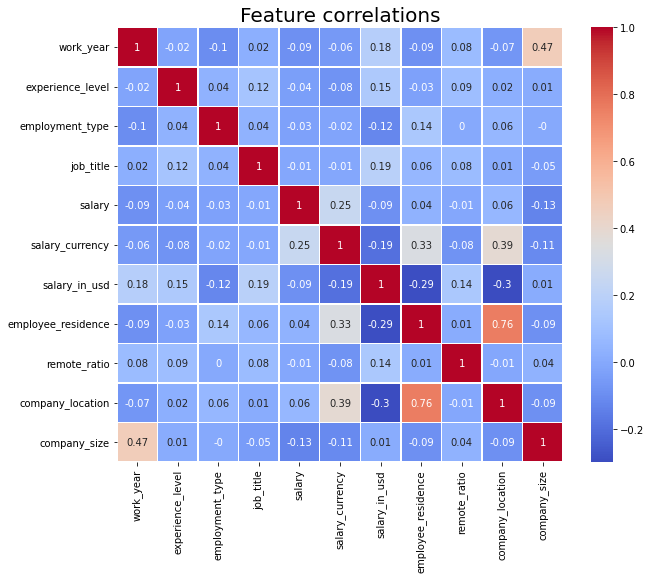

In [ ]:
plt.figure(figsize=(10, 8))

corr_matrix = df.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature correlations", size=20)

plt.savefig("feature_correlations.png")

In [ ]:
print(df.columns)

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')


In [ ]:
print("salary currencies:\n{}".format(mapp["salary_currency"]))
print("employee residences:\n{}".format(mapp["employee_residence"]))

salary currencies:
{'EUR': 0, 'USD': 1, 'GBP': 2, 'HUF': 3, 'INR': 4, 'JPY': 5, 'CNY': 6, 'MXN': 7, 'CAD': 8, 'DKK': 9, 'PLN': 10, 'SGD': 11, 'CLP': 12, 'BRL': 13, 'TRY': 14, 'AUD': 15, 'CHF': 16}
employee residences:
{'DE': 0, 'JP': 1, 'GB': 2, 'HN': 3, 'US': 4, 'HU': 5, 'NZ': 6, 'FR': 7, 'IN': 8, 'PK': 9, 'PL': 10, 'PT': 11, 'CN': 12, 'GR': 13, 'AE': 14, 'NL': 15, 'MX': 16, 'CA': 17, 'AT': 18, 'NG': 19, 'PH': 20, 'ES': 21, 'DK': 22, 'RU': 23, 'IT': 24, 'HR': 25, 'BG': 26, 'SG': 27, 'BR': 28, 'IQ': 29, 'VN': 30, 'BE': 31, 'UA': 32, 'MT': 33, 'CL': 34, 'RO': 35, 'IR': 36, 'CO': 37, 'MD': 38, 'KE': 39, 'SI': 40, 'HK': 41, 'TR': 42, 'RS': 43, 'PR': 44, 'LU': 45, 'JE': 46, 'CZ': 47, 'AR': 48, 'DZ': 49, 'TN': 50, 'MY': 51, 'EE': 52, 'AU': 53, 'BO': 54, 'IE': 55, 'CH': 56}


In [ ]:
df.drop(labels=["salary", "salary_currency"], axis=1, inplace=True)

In [ ]:
df.drop(labels=["work_year"], axis=1, inplace=True)

In [ ]:
display(df)

,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,0,0,70343,0,0,0,0
1,1,0,1,260000,1,0,1,1
2,1,0,2,98338,2,50,2,2
3,0,0,3,20000,3,0,3,1
4,1,0,4,150000,4,50,4,0
...,...,...,...,...,...,...,...,...
602,1,0,10,154000,4,100,4,2
603,1,0,10,126000,4,100,4,2
604,1,0,5,129000,4,0,4,2
605,1,0,5,150000,4,100,4,2


### Dimensionality Reduction

In [ ]:
columns = df.columns.tolist()

y_column = "salary_in_usd"
columns.remove(y_column)
x_columns = columns

x = df[x_columns]
y = df[[y_column]]

display(x, y)

,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
0,0,0,0,0,0,0,0
1,1,0,1,1,0,1,1
2,1,0,2,2,50,2,2
3,0,0,3,3,0,3,1
4,1,0,4,4,50,4,0
...,...,...,...,...,...,...,...
602,1,0,10,4,100,4,2
603,1,0,10,4,100,4,2
604,1,0,5,4,0,4,2
605,1,0,5,4,100,4,2


,salary_in_usd
0,70343
1,260000
2,98338
3,20000
4,150000
...,...
602,154000
603,126000
604,129000
605,150000


In [ ]:
fts = x.columns.tolist()

pca = PCA(n_components=1, random_state=123)
pca.fit(x[fts])

x["features"] = pca.transform(x.loc[:, tuple(fts)]).flatten()
x.drop(labels=fts, axis=1, inplace=True)

In [ ]:
display(x, y)

,features
0,71.154521
1,71.127038
2,21.116893
3,71.079494
4,21.069433
...,...
602,-29.063504
603,-29.063504
604,71.027592
605,-28.941403


,salary_in_usd
0,70343
1,260000
2,98338
3,20000
4,150000
...,...
602,154000
603,126000
604,129000
605,150000


### Train Test Split

In [ ]:
def gss(dataset_length, test_size, val_size):
    test = round(dataset_length * test_size)
    train = dataset_length - test
    val = round(train * val_size)

    train = train - val

    return (train, test, val)

In [ ]:
sz = [0.05, 0.1, 0.2, 0.3, 0.4]

for size in sz:
    for val_size in sz:
        train, test, val = gss(len(df), size, val_size)
            
        print(f"dataset training size for test size of {size} and validation size of {val_size}: \n\ttrain data: {train}\n\ttest data: {test}\n\tvalidation data: {val}")

dataset training size for test size of 0.05 and validation size of 0.05: 
	train data: 548
	test data: 30
	validation data: 29
dataset training size for test size of 0.05 and validation size of 0.1: 
	train data: 519
	test data: 30
	validation data: 58
dataset training size for test size of 0.05 and validation size of 0.2: 
	train data: 462
	test data: 30
	validation data: 115
dataset training size for test size of 0.05 and validation size of 0.3: 
	train data: 404
	test data: 30
	validation data: 173
dataset training size for test size of 0.05 and validation size of 0.4: 
	train data: 346
	test data: 30
	validation data: 231
dataset training size for test size of 0.1 and validation size of 0.05: 
	train data: 519
	test data: 61
	validation data: 27
dataset training size for test size of 0.1 and validation size of 0.1: 
	train data: 491
	test data: 61
	validation data: 55
dataset training size for test size of 0.1 and validation size of 0.2: 
	train data: 437
	test data: 61
	validation

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

display(x_train, y_train, x_test, y_test)

,features
269,20.920234
448,-29.063504
138,70.638787
486,-28.819302
93,70.956250
...,...
226,-28.821835
476,-28.819302
454,70.659454
606,-29.292512


,salary_in_usd
269,55269
448,180000
138,220000
486,230000
93,276000
...,...
226,84575
476,185100
454,125000
606,200000


,features
401,-29.061585
437,-29.064088
251,-28.820177
258,21.069433
402,71.027592
...,...
316,-29.064801
11,71.152371
580,-28.941403
375,-29.020866


,salary_in_usd
401,154600
437,80392
251,90000
258,185000
402,115934
...,...
316,40492
11,37699
580,126500
375,115329


## Modelling

### Creating a Basline

In [ ]:
def create_baseline(x, y):
    baseline_model = KNeighborsRegressor()
    aval_params = [{"n_neighbors": (range(10, 50)), "algorithm": ("ball_tree", "kd_tree", "brute"), "metric": ("minkowski", "euclidean")}]

    gridsearch = GridSearchCV(baseline_model, aval_params, cv=15, scoring="neg_mean_squared_error")
    gridsearch.fit(x, y)

    best_params = gridsearch.best_params_

    baseline_model = KNeighborsRegressor(
        algorithm=best_params["algorithm"], 
        metric=best_params["metric"], 
        n_neighbors=best_params["n_neighbors"]
    )

    baseline_model.fit(x, y)
    print(f"baseline score: {gridsearch.best_score_}")
    
    return baseline_model

In [ ]:
baseline = create_baseline(x_train, y_train)

baseline score: -4905339259.692402


### Model Development

In [ ]:
model = Sequential()

model.add(Dense(64, activation="relu", kernel_initializer="normal"))
model.add(Dense(32, activation="relu", kernel_initializer="normal"))
model.add(Dropout(0.6))
model.add(Dense(1, kernel_initializer="normal"))

model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["mse"]
)

In [ ]:
model.build(input_shape=(None, 1))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                128       
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


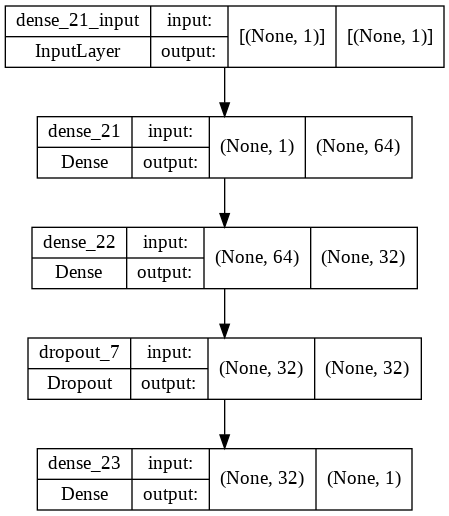

In [ ]:
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(
    x_train.values,
    y_train.values,
    validation_split=0.2,
    epochs=232,
    verbose=0
)

In [ ]:
def get_result(model, x, y):
    y_pred = model.predict(x).flatten()
    y = y.reset_index()
    x = x.reset_index()

    y.drop(labels=["index"], axis=1, inplace=True)
    x.drop(labels=["index"], axis=1, inplace=True)

    y_hats = list()

    for y_hat in y_pred:
        y_hats.append(round(y_hat))

    result = pd.concat([x, 
                        y, 
                        pd.DataFrame(y_hats, columns=["y_hat"])], 
                    axis=1)

    return result

In [ ]:
model_result = get_result(model, x_test, y_test)

display(model_result)

,features,salary_in_usd,y_hat
0,-29.061585,154600,109680
1,-29.064088,80392,109689
2,-28.820177,90000,108799
3,21.069433,185000,29675
4,71.027592,115934,94408
...,...,...,...
56,-29.064801,40492,109692
57,71.152371,37699,94569
58,-28.941403,126500,109242
59,-29.020866,115329,109532


In [ ]:
baseline_result = get_result(baseline, x_test, y_test)

display(baseline_result)

,features,salary_in_usd,y_hat
0,-29.061585,154600,124269
1,-29.064088,80392,116400
2,-28.820177,90000,134546
3,21.069433,185000,67717
4,71.027592,115934,92816
...,...,...,...
56,-29.064801,40492,118036
57,71.152371,37699,96558
58,-28.941403,126500,102641
59,-29.020866,115329,107374


In [ ]:
def get_report(model_dict, x_train, y_train, x_test, y_test):
    mse = pd.DataFrame(columns=["train", "test"], index=model_dict.keys())

    for name, model in model_dict.items():
        mse.loc[name, "train"] = mean_squared_error(y_true=y_train, y_pred=model.predict(x_train))/1e3 
        mse.loc[name, "test"] = mean_squared_error(y_true=y_test, y_pred=model.predict(x_test))/1e3

    return mse

In [ ]:
model_dict = {"baseline_knn": baseline, "neural_networks": model}

report1 = get_report(model_dict, x_train, y_train, x_test, y_test)
display(report1)

,train,test
baseline_knn,4732700.402276,3265801.881426
neural_networks,5508900.927871,3827296.15978


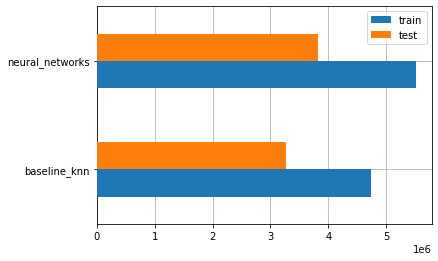

In [ ]:
fig, ax = plt.subplots()
report1.sort_values(by="test", ascending=True).plot(kind="barh", ax=ax, zorder=3)
ax.grid(zorder=0)

### Saving Both Models

In [ ]:
# deep learning model
model.save("/content/predictor.h5")

# traditional model
with open("knn_predictor.pkl", "wb") as f:
    pickle.dump(baseline, f)